# **Bioinformatics Project - Computational Drug Discovery Exploratory Data Analysis**

Sanket Palve

Thanks to Chanin Nantasenamat

[*'Data Professor' YouTube channel*](http://youtube.com/dataprofessor)


## **Install conda and rdkit**

In [2]:
# @title
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2024-09-08 11:03:17--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M  98.5MB/s    in 0.8s    

2024-09-08 11:03:18 (98.5 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handlin

## **Load bioactivity data**

In [49]:
import pandas as pd
df= pd.read_csv('mycobacterium_tuberculosis_bioactivity_data_curated.csv')

In [50]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [51]:
df_no_smiles


,molecule_chembl_id,standard_value,class
0,CHEMBL47882,10.000,active
1,CHEMBL374478,147.000,active
2,CHEMBL175244,10.000,active
3,CHEMBL177834,10.000,active
4,CHEMBL369695,62.500,active
...,...,...,...
1810,CHEMBL5177297,1.800,active
1811,CHEMBL5277032,0.013,active
1812,CHEMBL5290063,0.012,active
1813,CHEMBL5270552,0.011,active


In [9]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [10]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL47882,10.000,active,C=CCNC(=S)Nc1ccc(-c2nnc(SCc3ccc(Cl)cc3Cl)n2C)cc1
1,CHEMBL374478,147.000,active,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...
2,CHEMBL175244,10.000,active,CCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OC(C)(C)C
3,CHEMBL177834,10.000,active,CCCCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OCC
4,CHEMBL369695,62.500,active,CCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OCC
...,...,...,...,...
1810,CHEMBL5177297,1.800,active,O=C(/C=C/c1nccs1)N1CCN(Cc2ccc3c(c2)OCO3)CC1
1811,CHEMBL5277032,0.013,active,CCSc1nc(NC)c2cccc(F)c2n1
1812,CHEMBL5290063,0.012,active,CCSc1nc(NC)c2ccccc2n1
1813,CHEMBL5270552,0.011,active,CCNc1nc(SCC)nc2ccccc12


## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

### **Import libraries**

In [11]:
!pip uninstall -y rdkit
!pip install rdkit-pypi

     |████████████████████████████████| 29.2 MB 1.5 MB/s 


In [12]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [13]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [14]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,464.447,5.55360,2.0,5.0
1,822.953,4.33542,6.0,15.0
2,406.596,5.40080,0.0,7.0
3,406.596,5.40240,0.0,7.0
4,378.542,4.62220,0.0,7.0
...,...,...,...,...
1810,357.435,2.22940,0.0,6.0
1811,237.303,2.92260,1.0,4.0
1812,219.313,2.78350,1.0,4.0
1813,233.340,3.17360,1.0,4.0


### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [15]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,464.447,5.55360,2.0,5.0
1,822.953,4.33542,6.0,15.0
2,406.596,5.40080,0.0,7.0
3,406.596,5.40240,0.0,7.0
4,378.542,4.62220,0.0,7.0
...,...,...,...,...
1810,357.435,2.22940,0.0,6.0
1811,237.303,2.92260,1.0,4.0
1812,219.313,2.78350,1.0,4.0
1813,233.340,3.17360,1.0,4.0


In [16]:
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL47882,C=CCNC(=S)Nc1ccc(-c2nnc(SCc3ccc(Cl)cc3Cl)n2C)cc1,10.000,active
1,CHEMBL374478,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...,147.000,active
2,CHEMBL175244,CCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OC(C)(C)C,10.000,active
3,CHEMBL177834,CCCCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OCC,10.000,active
4,CHEMBL369695,CCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OCC,62.500,active
...,...,...,...,...
1810,CHEMBL5177297,O=C(/C=C/c1nccs1)N1CCN(Cc2ccc3c(c2)OCO3)CC1,1.800,active
1811,CHEMBL5277032,CCSc1nc(NC)c2cccc(F)c2n1,0.013,active
1812,CHEMBL5290063,CCSc1nc(NC)c2ccccc2n1,0.012,active
1813,CHEMBL5270552,CCNc1nc(SCC)nc2ccccc12,0.011,active


Now, let's combine the 2 DataFrame

In [17]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [18]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL47882,C=CCNC(=S)Nc1ccc(-c2nnc(SCc3ccc(Cl)cc3Cl)n2C)cc1,10.000,active,464.447,5.55360,2.0,5.0
1,CHEMBL374478,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...,147.000,active,822.953,4.33542,6.0,15.0
2,CHEMBL175244,CCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OC(C)(C)C,10.000,active,406.596,5.40080,0.0,7.0
3,CHEMBL177834,CCCCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OCC,10.000,active,406.596,5.40240,0.0,7.0
4,CHEMBL369695,CCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OCC,62.500,active,378.542,4.62220,0.0,7.0
...,...,...,...,...,...,...,...,...
1810,CHEMBL5177297,O=C(/C=C/c1nccs1)N1CCN(Cc2ccc3c(c2)OCO3)CC1,1.800,active,357.435,2.22940,0.0,6.0
1811,CHEMBL5277032,CCSc1nc(NC)c2cccc(F)c2n1,0.013,active,237.303,2.92260,1.0,4.0
1812,CHEMBL5290063,CCSc1nc(NC)c2ccccc2n1,0.012,active,219.313,2.78350,1.0,4.0
1813,CHEMBL5270552,CCNc1nc(SCC)nc2ccccc12,0.011,active,233.340,3.17360,1.0,4.0


### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [19]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)

    return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [20]:
df_combined.standard_value.describe()

,standard_value
count,1.815000e+03
mean,1.175701e+07
std,2.946895e+08
min,1.100000e-02
25%,1.000000e+02
50%,6.930000e+03
75%,5.141000e+04
max,1.240000e+10


In [21]:
-np.log10( (10**-9)* 100000000 )

1.0

In [22]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [23]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1) # Use axis=1 to specify that a column should be dropped

    return x

We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [24]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL47882,C=CCNC(=S)Nc1ccc(-c2nnc(SCc3ccc(Cl)cc3Cl)n2C)cc1,active,464.447,5.55360,2.0,5.0,10.000
1,CHEMBL374478,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...,active,822.953,4.33542,6.0,15.0,147.000
2,CHEMBL175244,CCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OC(C)(C)C,active,406.596,5.40080,0.0,7.0,10.000
3,CHEMBL177834,CCCCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OCC,active,406.596,5.40240,0.0,7.0,10.000
4,CHEMBL369695,CCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OCC,active,378.542,4.62220,0.0,7.0,62.500
...,...,...,...,...,...,...,...,...
1810,CHEMBL5177297,O=C(/C=C/c1nccs1)N1CCN(Cc2ccc3c(c2)OCO3)CC1,active,357.435,2.22940,0.0,6.0,1.800
1811,CHEMBL5277032,CCSc1nc(NC)c2cccc(F)c2n1,active,237.303,2.92260,1.0,4.0,0.013
1812,CHEMBL5290063,CCSc1nc(NC)c2ccccc2n1,active,219.313,2.78350,1.0,4.0,0.012
1813,CHEMBL5270552,CCNc1nc(SCC)nc2ccccc12,active,233.340,3.17360,1.0,4.0,0.011


In [25]:
df_norm.standard_value_norm.describe()

,standard_value_norm
count,1.815000e+03
mean,1.810169e+06
std,1.278733e+07
min,1.100000e-02
25%,1.000000e+02
50%,6.930000e+03
75%,5.141000e+04
max,1.000000e+08


In [26]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1) #Corrected line: Use axis=1 to specify that a column should be dropped

    return x

In [27]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL47882,C=CCNC(=S)Nc1ccc(-c2nnc(SCc3ccc(Cl)cc3Cl)n2C)cc1,active,464.447,5.55360,2.0,5.0,8.000000
1,CHEMBL374478,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...,active,822.953,4.33542,6.0,15.0,6.832683
2,CHEMBL175244,CCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OC(C)(C)C,active,406.596,5.40080,0.0,7.0,8.000000
3,CHEMBL177834,CCCCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OCC,active,406.596,5.40240,0.0,7.0,8.000000
4,CHEMBL369695,CCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OCC,active,378.542,4.62220,0.0,7.0,7.204120
...,...,...,...,...,...,...,...,...
1810,CHEMBL5177297,O=C(/C=C/c1nccs1)N1CCN(Cc2ccc3c(c2)OCO3)CC1,active,357.435,2.22940,0.0,6.0,8.744727
1811,CHEMBL5277032,CCSc1nc(NC)c2cccc(F)c2n1,active,237.303,2.92260,1.0,4.0,10.886057
1812,CHEMBL5290063,CCSc1nc(NC)c2ccccc2n1,active,219.313,2.78350,1.0,4.0,10.920819
1813,CHEMBL5270552,CCNc1nc(SCC)nc2ccccc12,active,233.340,3.17360,1.0,4.0,10.958607


In [28]:
df_final.pIC50.describe()

,pIC50
count,1815.000000
mean,5.596558
std,1.710377
min,1.000000
25%,4.288952
50%,5.159267
75%,7.000000
max,10.958607


Let's write this to CSV file.

In [29]:
df_final.to_csv('mycobacterium_tuberculosis_bioactivity_data_3class_pIC50.csv')

### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [30]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL47882,C=CCNC(=S)Nc1ccc(-c2nnc(SCc3ccc(Cl)cc3Cl)n2C)cc1,active,464.447,5.55360,2.0,5.0,8.000000
1,CHEMBL374478,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...,active,822.953,4.33542,6.0,15.0,6.832683
2,CHEMBL175244,CCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OC(C)(C)C,active,406.596,5.40080,0.0,7.0,8.000000
3,CHEMBL177834,CCCCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OCC,active,406.596,5.40240,0.0,7.0,8.000000
4,CHEMBL369695,CCCCCCCCCCSc1ncnc2c1ncn2CC(=O)OCC,active,378.542,4.62220,0.0,7.0,7.204120
...,...,...,...,...,...,...,...,...
1809,CHEMBL5281967,O=C(/C=C/c1ccccc1)N1CCN(Cc2ccc3c(c2)OCO3)CC1,active,350.418,2.77290,0.0,4.0,9.522879
1810,CHEMBL5177297,O=C(/C=C/c1nccs1)N1CCN(Cc2ccc3c(c2)OCO3)CC1,active,357.435,2.22940,0.0,6.0,8.744727
1811,CHEMBL5277032,CCSc1nc(NC)c2cccc(F)c2n1,active,237.303,2.92260,1.0,4.0,10.886057
1812,CHEMBL5290063,CCSc1nc(NC)c2ccccc2n1,active,219.313,2.78350,1.0,4.0,10.920819


Let's write this to CSV file.

In [31]:
df_2class.to_csv('mycobacterium_tuberculosis_bioactivity_data_2class_pIC50.csv')

---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [32]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

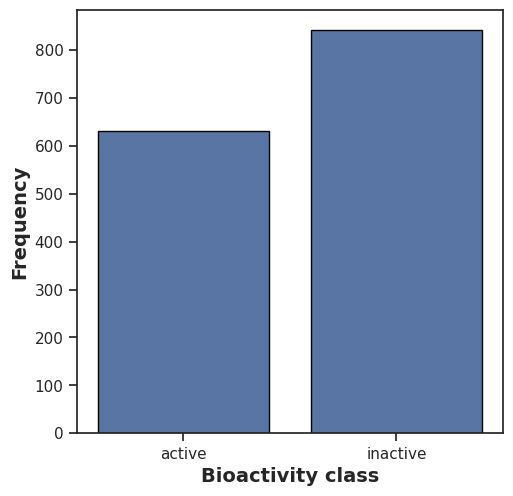

In [33]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

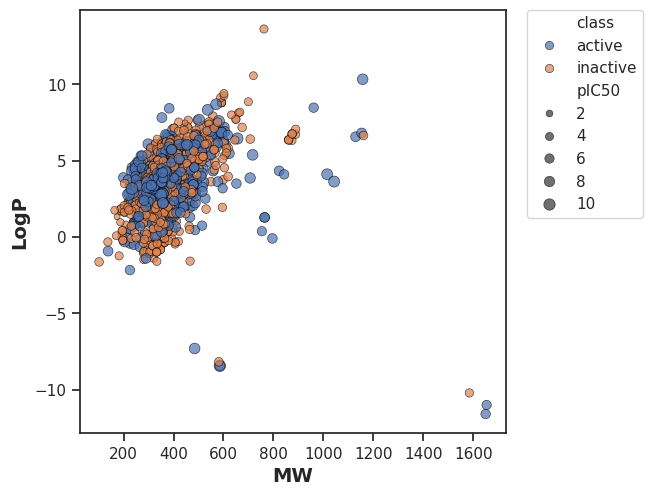

In [34]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### **Box plots**

#### **pIC50 value**

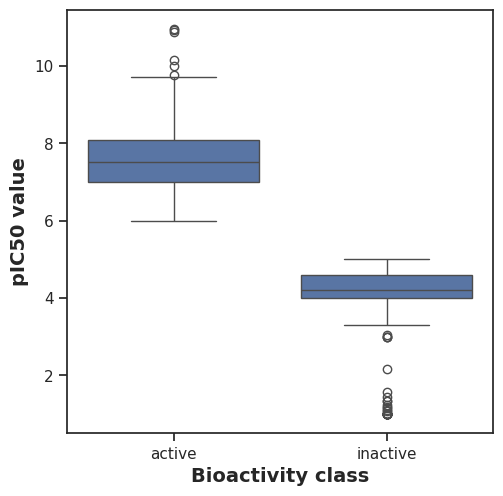

In [35]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [36]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [37]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,532144.0,4.863815e-238,0.05,Different distribution (reject H0)


#### **MW**

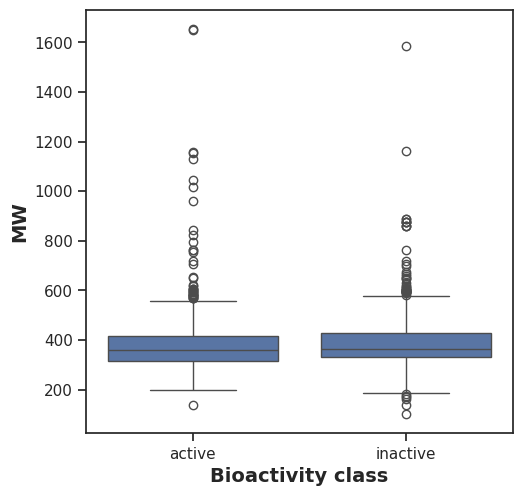

In [38]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [39]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,252912.5,0.103725,0.05,Same distribution (fail to reject H0)


#### **LogP**

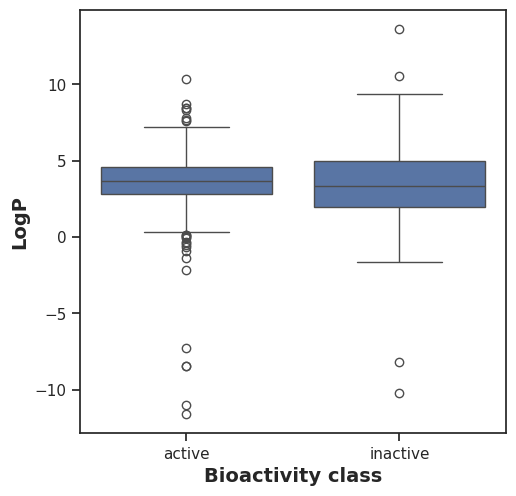

In [40]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [41]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,290418.0,0.002611,0.05,Different distribution (reject H0)


#### **NumHDonors**

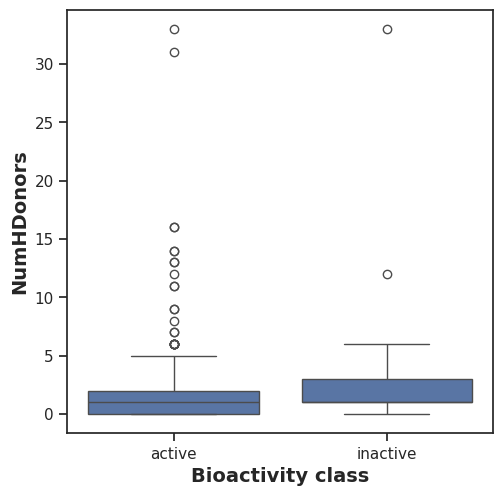

In [42]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [43]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,216795.5,3.143545e-10,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

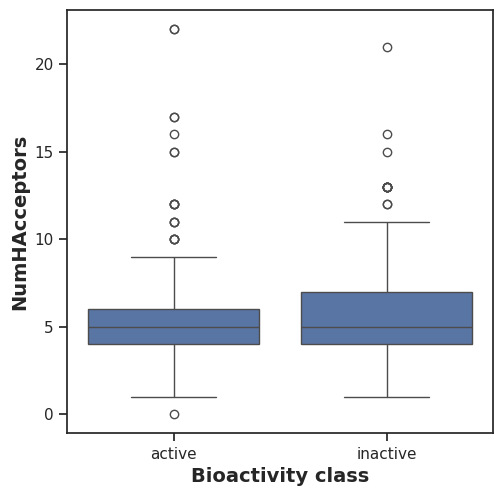

In [44]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [45]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,223098.0,7.804422e-08,0.05,Different distribution (reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

All of the 4 Lipinski's descriptors exhibited ***statistically significant difference*** between the **actives** and **inactives**.

## **Zip files**

In [46]:
! zip -r results.zip . -i *.csv *.pdf

  adding: mannwhitneyu_MW.csv (deflated 8%)
  adding: plot_bioactivity_class.pdf (deflated 37%)
  adding: plot_NumHAcceptors.pdf (deflated 39%)
  adding: mycobacterium_tuberculosis_bioactivity_data_3class_pIC50.csv (deflated 76%)
  adding: plot_NumHDonors.pdf (deflated 39%)
  adding: mycobacterium_tuberculosis_bioactivity_data_2class_pIC50.csv (deflated 76%)
  adding: plot_MW.pdf (deflated 37%)
  adding: plot_LogP.pdf (deflated 40%)
  adding: mycobacterium_tuberculosis_bioactivity_data_curated.csv (deflated 82%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: mycobacterium_tuberculosis_bioactivity_data_raw.csv (deflated 93%)
  adding: plot_MW_vs_LogP.pdf (deflated 3%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 11%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 10%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: mycobacterium_tuberculosis_bioactivity_data_preprocessed.csv (deflated 80%)
  adding: mannwhitneyu_LogP.csv (deflated 10%)
